**Task 2**

In [27]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import getpass
from tqdm.notebook import  tqdm
import csv

from datetime import datetime, timedelta

from sklearn.metrics import mean_absolute_error

from lightgbm import LGBMRegressor

import optuna
import ast

from pathlib import Path

In [2]:
def samples_split_by_order(X, y=None, date_col='time', date=None, split_by_date=False, sec_size=0.2):
    '''Divide samples by order
    
    Parameters:
        X - dataframe
        y - series or dataframe
        X, y must be already ordered by some order
        If y isn't given thеn only X is divided
        
        date_col - name of column that indicate monthly date, default='month_camp'
        
        date - 1-st sample created strictly till (before!) this date, 2-d after including the 'date' if 'date' is not None
        
        split_by_date - bool, split samples by date if True (date must be given)
        
        sec_size - fraction of second size of sample
        
        If split_by_date is True then division makes by date and column "month_camp must be" else by frac
        
    Return:
        samples divided by order in format X_first, X_second (optionally y_first, y_second)
    '''
    
    if date is not None and not split_by_date:
        raise ValueError('Get date but parameter split_by_date is False. It should be True')
    elif date is None and split_by_date:
        raise ValueError('Get splitby_date=True but date is not found')
    
    cnt_rows_1 = np.where(X[date_col]>=date)[0][0] if split_by_date else int(X.shape[0] * (1 - sec_size))
    
    X_fir, X_sec = X.iloc[:cnt_rows_1, :], X.iloc[cnt_rows_1:, :]
    
    return (X_fir, X_sec, y[:cnt_rows_1], y[cnt_rows_1:]) if y is not None else (X_fir, X_sec)

#seems that this helps to decrease overfitting without losing much quality
def compute_diff_div_sensors(sample):
    """Compute division and difference for i'th (1 to 3) sensor in different cells (1 to 5)"""
    
    for i in range(1, 5):
        for j in range(1, 4):
            sample[f'T_data_{j}_div_{i+1}{i}'] = sample[f'T_data_{i+1}_{j}'] / sample[f'T_data_{i}_{j}'] 
            
            sample[f'T_data_{j}_diff_{i+1}{i}'] = sample[f'T_data_{i+1}_{j}'] - sample[f'T_data_{i}_{j}'] 
            
    return sample

In [6]:
pd.set_option('display.max_columns', 100)
sns.set(style='darkgrid')

SEED = 42
NJOBS = 60
NEG_CONST = -1000

DATA_DIR = Path('') #path to data files
OPTIMIZE_FILE = DATA_DIR / 'optuna_scores.csv'

In [7]:
data = pd.read_csv(DATA_DIR / 'X_data.csv', sep=';')
data.columns = ['time'] + list(data.columns[1:])
data['time'] = pd.to_datetime(data['time'], format='%Y-%m-%d %H:%M:%S')

ytrain = pd.read_csv(DATA_DIR / 'Y_train.csv', sep=';', header=None)
ytrain.columns = ['time', 'value']
ytrain['time'] = pd.to_datetime(ytrain['time'], format='%Y-%m-%d %H:%M:%S')

ytest = pd.read_csv(DATA_DIR / 'Y_submit.csv', sep=';', header=None)
ytest.columns = ['time', 'value']
ytest['time'] = pd.to_datetime(ytest['time'], format='%Y-%m-%d %H:%M:%S')

#change 420 to -1 because true data (train part) can contain 420 and then we won't be able to split common df
ytest['value'] = -1

In [8]:
df = data.merge(pd.concat([ytrain, ytest]), on=['time'], how='left')
df['value'] = df['value'].fillna(NEG_CONST)
print(df.shape)

(2103841, 19)


## Data preprocessing

**Add some features**

In [9]:
df = compute_diff_div_sensors(df)

**Add lag features**

Since we got values in the end (after one hour), I suppose that current hour is for the certain steel or smth like that

In [10]:
index_cols = ['time']
lag_features = ['T_data_1_1', 'T_data_1_2', 'T_data_1_3', 'T_data_2_1', 'T_data_2_2', 'T_data_2_3',
                 'T_data_3_1', 'T_data_3_2', 'T_data_3_3', 'T_data_4_1', 'T_data_4_2', 'T_data_4_3',
                 'T_data_5_1', 'T_data_5_2', 'T_data_5_3']

In [11]:
#in minutes
lag_steps = list(range(10, 60, 10))

for step in tqdm(lag_steps):
    df_shift = df[index_cols + lag_features].copy()
    
    df['time'] += timedelta(minutes=step)
    #rename columns based on lag step
    df_shift = df_shift.rename(columns=lambda x: f'{x}_lag_{step}' if x in lag_features else x)
    
    df = pd.merge(df, df_shift, on=index_cols, how='left')

In [12]:
#drop rows without target
df = df[df['value']!=NEG_CONST]
#just in case
df = df.sort_values(by=['time'])
print(df.shape)

(34992, 118)


**Some plots**

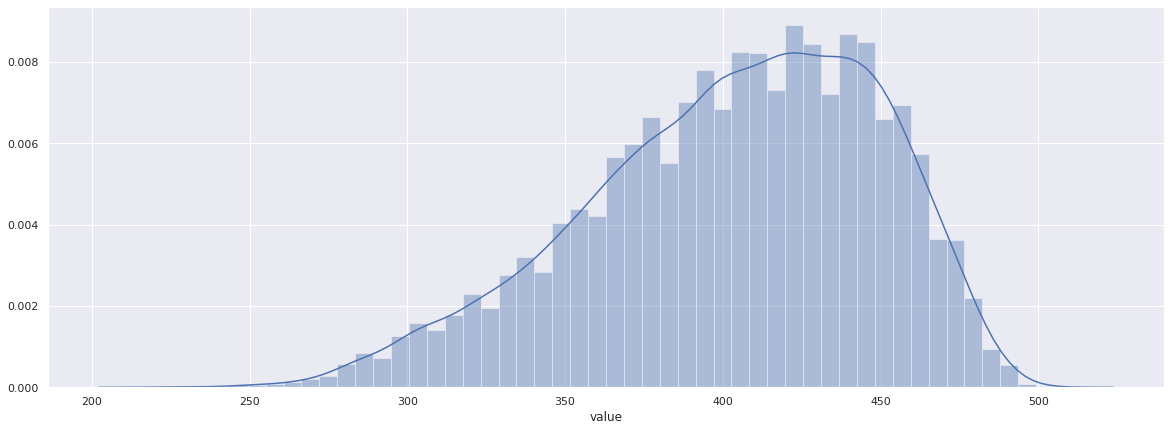

In [9]:
plt.figure(figsize=(20, 7))
sns.distplot(df.loc[df['value']!=-1, 'value'])
plt.show()

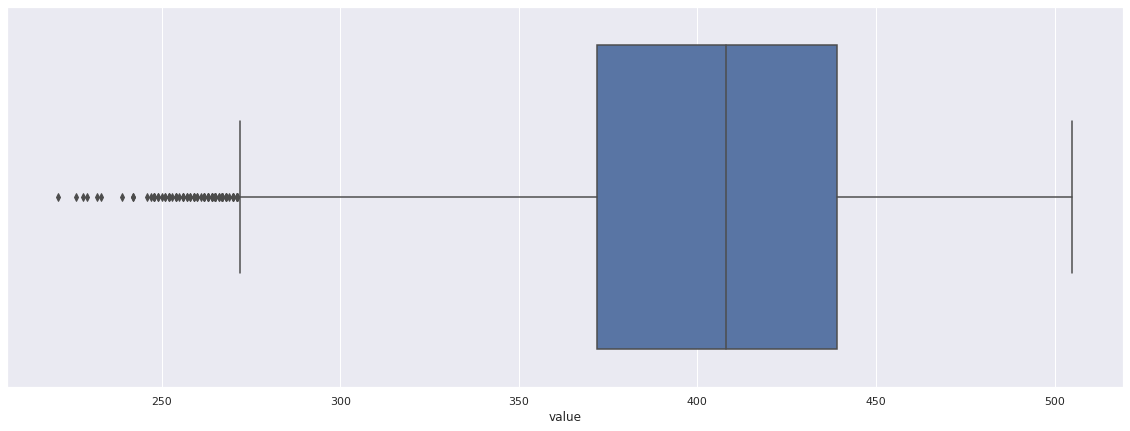

In [10]:
plt.figure(figsize=(20, 7))
sns.boxplot(df.loc[df['value']!=-1, 'value'])
plt.show()

In [11]:
df.isna().sum().sum()

0

Seems no extreme values and also there're no missing values

**Split data**

In [13]:
Xtrain, Xval, ytrain, yval = samples_split_by_order(df.loc[df['value']!=-1].drop('value', axis=1)
                                                    , df.loc[df['value']!=-1,'value']
                                                    , date_col='time', sec_size=0.2)

Xtest = df.loc[df['value']==-1].drop('value', axis=1)

print(Xtrain.shape, Xval.shape, Xtest.shape)

(23347, 117) (5837, 117) (5808, 117)


In [14]:
Xtrain = Xtrain.drop(['time'], axis=1)
Xval = Xval.drop(['time'], axis=1)
Xtest = Xtest.drop('time', axis=1)

Xtrain = Xtrain.reindex(sorted(Xtrain.columns), axis=1)
Xval = Xval.reindex(sorted(Xval.columns), axis=1)
Xtest = Xtest.reindex(sorted(Xtest.columns), axis=1)

## Simple baseline

Since target metrics is MAE, I'll check median

In [123]:
m = np.median(ytrain)
print(mean_absolute_error(ytrain, [m]*Xtrain.shape[0]))
print(mean_absolute_error(yval, [m]*Xval.shape[0]))

37.40493425279479
38.21175261264348


## Optuna

lgbm

In [15]:
N_EST = 5000
INT_PARAMS = ['n_estimators', 'max_depth', 'subsample_for_bin', 'min_data_in_leaf', 'subsample_freq'
              , 'random_state', 'n_jobs', 'num_leaves']

In [19]:
def objective(trial):

    params = {'n_estimators': N_EST
             , 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1)
             , 'num_leaves': trial.suggest_int('num_leaves', 7, 255)
             , 'max_depth': -1
             , 'subsample': trial.suggest_uniform('subsample', 0.75, 1)
             , 'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1)
             , 'min_child_weight': trial.suggest_uniform('min_child_weight', 1e-1, 200)
             , 'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 3.0)
             , 'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 3.0)
             , 'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-2, 100) #aka gamma in xgboost
             , 'max_delta_step': trial.suggest_uniform('max_delta_step', 0, 100)
             , 'subsample_for_bin': trial.suggest_int('subsample_for_bin', 50*1000, 300*1000)
             , 'subsample_freq': trial.suggest_int('subsample_freq', 1, 10)
             , 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, int(0.05 * Xtrain.shape[0]))
              
             , 'random_state': SEED
             , 'n_jobs' : NJOBS
            }
    
    start_time = datetime.now()

    model = LGBMRegressor(**params)
    model.fit(Xtrain, ytrain, eval_metric=['mae'], verbose=False
            , eval_set=[(Xval, yval)], early_stopping_rounds=100)
    
    train_time = datetime.now() - start_time

    pred_val = model.predict(Xval)
    pred_train = model.predict(Xtrain)
    
    mae_test = mean_absolute_error(yval, pred_val)
    mae_train = mean_absolute_error(ytrain, pred_train)
    
    with open(OPTIMIZE_FILE, 'a') as f:
        writer = csv.writer(f)
        writer.writerow([params, mae_test, mae_train, train_time])
    
    return mae_test

In [22]:
with open(OPTIMIZE_FILE, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['params', 'mae_test', 'mae_train', 'train_time'])

In [ ]:
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.SuccessiveHalvingPruner())
study.optimize(objective, n_trials=25, show_progress_bar=True, n_jobs=1)

In [24]:
print('Best parameters:\n')
print(study.best_params)

Best parameters:

{'learning_rate': 0.0038839813894882037, 'num_leaves': 108, 'subsample': 0.9188815849750354, 'colsample_bytree': 0.9071487529897371, 'min_child_weight': 147.5913889169944, 'reg_alpha': 1.3816062094693806, 'reg_lambda': 0.308926608897074, 'min_split_gain': 30.908513807597696, 'max_delta_step': 82.31736075874589, 'subsample_for_bin': 182395, 'subsample_freq': 8, 'min_data_in_leaf': 140}


In [25]:
print(study.best_value)

9.831925616798737


In [40]:
info_opt = pd.read_csv(DATA_DIR / OPTIMIZE_FILE)

info_opt_all = pd.DataFrame([ast.literal_eval(info_opt.loc[i, 'params']) for i in range(info_opt.shape[0])])
info_opt_all.insert(0, 'mae_test', info_opt['mae_test'])
info_opt_all.insert(1, 'mae_train', info_opt['mae_train'])
info_opt_all.insert(2, 'diff_mae', info_opt['mae_train'] - info_opt['mae_test'])

const_cols = ['n_estimators', 'random_state', 'n_jobs']

info_opt_all = info_opt_all.drop(const_cols, axis=1)
k=info_opt_all.sort_values(by=['mae_test'])
#k=info_opt_all[(info_opt_all['mae_test'] < 10)]

In [41]:
k

,mae_test,mae_train,diff_mae,learning_rate,num_leaves,max_depth,subsample,colsample_bytree,min_child_weight,reg_alpha,reg_lambda,min_split_gain,max_delta_step,subsample_for_bin,subsample_freq,min_data_in_leaf
18,9.831926,5.214602,-4.617323,0.003884,108,-1,0.918882,0.907149,147.591389,1.381606,0.308927,30.908514,82.317361,182395,8,140
17,9.838406,6.138651,-3.699755,0.005504,161,-1,0.918279,0.895653,166.186076,2.927903,0.479083,18.870808,99.919776,213779,8,138
16,9.848345,5.795628,-4.052716,0.006222,159,-1,0.920780,0.896145,139.901495,1.112859,0.487956,14.983234,87.872754,212929,8,169
14,9.859654,6.212379,-3.647276,0.006844,192,-1,0.960690,0.874684,172.421842,2.500262,2.734844,12.842631,94.191938,214216,1,307
20,9.861237,5.648004,-4.213233,0.004047,103,-1,0.900127,0.932698,139.853328,0.030139,0.050305,4.562445,80.051413,161357,7,143
21,9.882605,6.239158,-3.643447,0.006653,159,-1,0.930758,0.900909,136.394677,1.150060,0.769943,25.612485,90.738746,193486,8,160
2,9.884348,6.051967,-3.832381,0.037768,183,-1,0.986769,0.845035,122.287691,0.657430,2.706773,0.319870,54.447349,255450,10,260
22,9.887754,6.368758,-3.518996,0.003886,155,-1,0.933775,0.894534,178.018778,0.997496,0.250500,95.896391,95.898210,223188,9,146
13,9.902562,6.118503,-3.784059,0.024352,194,-1,0.953515,0.875348,198.051465,2.748009,2.962020,13.652203,48.150429,244604,4,242
15,9.907191,7.025298,-2.881893,0.006598,189,-1,0.956093,0.784580,173.589757,0.001083,2.961355,10.233740,99.210029,198852,1,444


In [42]:
#in my opinion 17 and 14 is ok
best_eval = 17

best_params = {'random_state': SEED
               , 'n_jobs' : NJOBS
               , 'n_estimators': N_EST
              }
best_params.update(dict(info_opt_all.drop(['mae_test', 'mae_train', 'diff_mae'], axis=1).loc[best_eval,:]))
for k, v in best_params.items():
    if k in INT_PARAMS:
        best_params[k] = int(v)
best_params

{'random_state': 42,
 'n_jobs': 60,
 'n_estimators': 5000,
 'learning_rate': 0.005503740183430079,
 'num_leaves': 161,
 'max_depth': -1,
 'subsample': 0.9182793578744269,
 'colsample_bytree': 0.8956534266619007,
 'min_child_weight': 166.1860762939183,
 'reg_alpha': 2.927903107984088,
 'reg_lambda': 0.4790832380802528,
 'min_split_gain': 18.870808224547016,
 'max_delta_step': 99.91977628403578,
 'subsample_for_bin': 213779,
 'subsample_freq': 8,
 'min_data_in_leaf': 138}

In [47]:
best_params['n_estimators'] = 5000
lgb1 = LGBMRegressor(**best_params)
lgb1.fit(Xtrain, ytrain, eval_metric=['mae'], verbose=200, early_stopping_rounds=100
             , eval_set=[(Xtrain, ytrain), (Xval, yval)])

Training until validation scores don't improve for 100 rounds
[200]	training's l1: 16.6677	training's l2: 444.118	valid_1's l1: 17.6953	valid_1's l2: 510.914
[400]	training's l1: 10.7036	training's l2: 196.323	valid_1's l1: 12.1357	valid_1's l2: 256.682
[600]	training's l1: 9.03228	training's l2: 144.795	valid_1's l1: 10.7259	valid_1's l2: 206.709
[800]	training's l1: 8.34802	training's l2: 125.213	valid_1's l1: 10.2776	valid_1's l2: 191.844
[1000]	training's l1: 7.90797	training's l2: 112.997	valid_1's l1: 10.0906	valid_1's l2: 185.976
[1200]	training's l1: 7.56846	training's l2: 103.805	valid_1's l1: 9.99294	valid_1's l2: 183.058
[1400]	training's l1: 7.28209	training's l2: 96.2105	valid_1's l1: 9.93922	valid_1's l2: 181.566
[1600]	training's l1: 7.01854	training's l2: 89.4227	valid_1's l1: 9.89843	valid_1's l2: 180.279
[1800]	training's l1: 6.78075	training's l2: 83.5067	valid_1's l1: 9.8759	valid_1's l2: 179.53
[2000]	training's l1: 6.56363	training's l2: 78.2785	valid_1's l1: 9.86

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.8956534266619007, importance_type='split',
              learning_rate=0.005503740183430079,
              max_delta_step=99.91977628403578, max_depth=-1,
              min_child_samples=20, min_child_weight=166.1860762939183,
              min_data_in_leaf=138, min_split_gain=18.870808224547016,
              n_estimators=10000, n_jobs=60, num_leaves=161, objective=None,
              random_state=42, reg_alpha=2.927903107984088,
              reg_lambda=0.4790832380802528, silent=True,
              subsample=0.9182793578744269, subsample_for_bin=213779,
              subsample_freq=8)

In [48]:
print(mean_absolute_error(ytrain, lgb1.predict(Xtrain)))
print(mean_absolute_error(yval, lgb1.predict(Xval)))

6.138650980745721
9.838405794688768


In [84]:
best_eval = 14

best_params = {'random_state': SEED
               , 'n_jobs' : NJOBS
               , 'n_estimators': N_EST
              }
best_params.update(dict(info_opt_all.drop(['mae_test', 'mae_train', 'diff_mae'], axis=1).loc[best_eval,:]))
for k, v in best_params.items():
    if k in INT_PARAMS:
        best_params[k] = int(v)
best_params

{'random_state': 42,
 'n_jobs': 60,
 'n_estimators': 5000,
 'learning_rate': 0.006844432997504232,
 'num_leaves': 192,
 'max_depth': -1,
 'subsample': 0.9606897306688151,
 'colsample_bytree': 0.8746843927456114,
 'min_child_weight': 172.4218421733197,
 'reg_alpha': 2.5002615091078826,
 'reg_lambda': 2.7348435293494426,
 'min_split_gain': 12.842631152793253,
 'max_delta_step': 94.1919381026021,
 'subsample_for_bin': 214216,
 'subsample_freq': 1,
 'min_data_in_leaf': 307}

In [85]:
best_params['n_estimators'] = 5000
lgb2 = LGBMRegressor(**best_params)
lgb2.fit(Xtrain, ytrain, eval_metric=['mae'], verbose=200, early_stopping_rounds=100
             , eval_set=[(Xtrain, ytrain), (Xval, yval)])

Training until validation scores don't improve for 100 rounds
[200]	training's l1: 15.1222	training's l2: 374.045	valid_1's l1: 16.1425	valid_1's l2: 432.792
[400]	training's l1: 10.4134	training's l2: 189.856	valid_1's l1: 11.6724	valid_1's l2: 240.223
[600]	training's l1: 9.3312	training's l2: 155.12	valid_1's l1: 10.7132	valid_1's l2: 206.566
[800]	training's l1: 8.84532	training's l2: 140.179	valid_1's l1: 10.391	valid_1's l2: 196.04
[1000]	training's l1: 8.51874	training's l2: 130.464	valid_1's l1: 10.2395	valid_1's l2: 191.545
[1200]	training's l1: 8.2582	training's l2: 122.84	valid_1's l1: 10.1504	valid_1's l2: 188.932
[1400]	training's l1: 8.02965	training's l2: 116.238	valid_1's l1: 10.0878	valid_1's l2: 186.902
[1600]	training's l1: 7.81939	training's l2: 110.263	valid_1's l1: 10.0359	valid_1's l2: 185.181
[1800]	training's l1: 7.61783	training's l2: 104.682	valid_1's l1: 9.98841	valid_1's l2: 183.553
[2000]	training's l1: 7.43586	training's l2: 99.7354	valid_1's l1: 9.95116	

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.8746843927456114, importance_type='split',
              learning_rate=0.006844432997504232,
              max_delta_step=94.1919381026021, max_depth=-1,
              min_child_samples=20, min_child_weight=172.4218421733197,
              min_data_in_leaf=307, min_split_gain=12.842631152793253,
              n_estimators=5000, n_jobs=60, num_leaves=192, objective=None,
              random_state=42, reg_alpha=2.5002615091078826,
              reg_lambda=2.7348435293494426, silent=True,
              subsample=0.9606897306688151, subsample_for_bin=214216,
              subsample_freq=1)

In [86]:
print(mean_absolute_error(ytrain, lgb2.predict(Xtrain)))
print(mean_absolute_error(yval, lgb2.predict(Xval)))

6.212378567305363
9.859654287889875


### Try to combine

In [126]:
alphas_to_try = np.linspace(0, 1, 1001)

pred_train1 = lgb1.predict(Xtrain)
pred_train2 = lgb2.predict(Xtrain)
min_mae = 1e9
best_alpha = -1
yhat_best = None
for alpha in alphas_to_try:
    yhat = pred_train1 * alpha + (1 - alpha) * pred_train2
    mae = mean_absolute_error(ytrain, yhat)
    if mae < min_mae:
        min_mae = mae
        best_alpha = alpha
        yhat_best = yhat

print(f'Best alpha: {best_alpha}\nCorresponding mae score on train: {mean_absolute_error(ytrain, yhat_best)}')

Best alpha: 0.9420000000000001
Corresponding mae score on train: 6.138352732948632


In [ ]:
best_alpha = 0.942

In [113]:
yhat_val = lgb1.predict(Xval) * best_alpha + (1 - best_alpha) * lgb2.predict(Xval)

print(f'val mae: {mean_absolute_error(yval, yhat_val)}')

val mae: 9.834184311237584


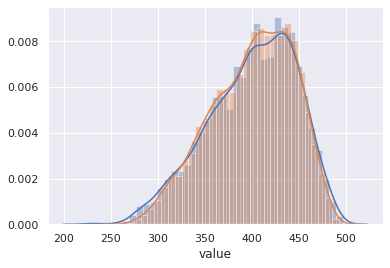

In [119]:
sns.distplot(yval)
sns.distplot(yhat_val)
plt.show()

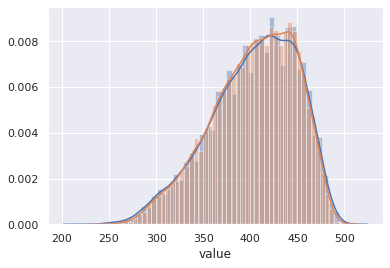

In [120]:
sns.distplot(ytrain)
sns.distplot(yhat_best)
plt.show()

## Predict on test

In [97]:
ytest['value'] = lgb1.predict(Xtest) * best_alpha + (1 - best_alpha) * lgb2.predict(Xtest)

In [99]:
ytest.to_csv(DATA_DIR / 'y_submit.csv', index=False)

## Sum up

As I noticed while training other models, it can be a bit better to use top 30 features (based on shap values). Also maybe single model 'lgb1' will win on Y_submit and in 'production' rather single model will be used than any stacking but just to try I prefer to keep this approach here.

By the way while training I tried to generate different features based on sensors and cells, computing different statistics like mean, max, min, std but it didn't have any success as it seemed to me